In [1]:
# All features: Final preprocessing list

# (1. current open minus previous close)

# 2. todays high - todays low
# 3. todays close - todays open


# should make data stationary. Use augmented dickey-fuller test to check for stationarity:
"""
from statsmodels.tsa.stattools import adfuller

# Assume `data` is a pandas DataFrame with 'Open' and 'Close' columns
data['Percent_Change'] = (data['Close'] - data['Open']) / data['Open']

# Perform the Augmented Dickey-Fuller test
adf_result = adfuller(data['Percent_Change'].dropna())

print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print('\t%s: %.3f' % (key, value))

# Interpretation
if adf_result[1] < 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary.")
"""

# 4. todays close - yesterday's close
# 5. todays open - todays low
# 6. todays open - todays high
# 7. todays close - todays low
# 8. todays close - todays high

# 4. month of year
# 5. week of year
# 6. day of year
# 7. day of month
# 8. day of week
# 9. hour of day (24h cycle)
# 10. Volume (normalized from 0 to 1)


# 11. Rolling window (SMA, EMA)
# 12. Fourier Transform
# 13. Wavelet Transform (discrete wavelet transform (adjust based on volatility: high volatility -> narrow the wavelet, low volatility -> widen the wavelet))
# ?? (Haar, Daubechies, Symlets, Coiflets, Biorthogonal, Reverse Biorthogonal, Discrete Meyer, Gaussian, Mexican Hat, Morlet, Complex Gaussian, Shannon, Frequency B-Spline, Complex Morlet, Generalized Morse, Complex Morlet, Paul, D4, D6, D8, D10, D12, D14, D16, D18, D20, D22, D24, D26, D28, D30, D32, D34, D36, D38, D40, D42, D44, D46, D48, D50, D52, D54, D56, D58, D60, D62, D64, D66, D68, D70, D72, D74, D76, D78, D80, D82, D84, D86, D88, D90, D92, D94, D96, D98, D100, D102, D104, D106, D108, D110, D112, D114, D116, D118, D120, D122, D124, D126, D128, D130, D132, D134, D136, D138, D140, D142, D144, D146, D148, D150, D152, D154, D156, D158, D160, D162, D164, D166, D168, D170, D172, D174, D176, D178, D180, D182, D184, D186, D188, D190, D192, D194, D196, D198, D200, D202, D204, D206, D208, D210, D212, D214, D216, D218, D220, D222, D224, D226, D228, D230, D232, D234, D236, D238, D240, D242, D244, D246, D248, D250, D252, D254, D256, D258, D260, D262, D264, D266, D268, D270, D272, D274, D276, D278, D280, D282, D284, D286, D288, D290, D292, D294, D)
# 14. Trading indicators (bullish or bearish divergence on the RSI, TD Sequential, Candlestick Patterns)


# Alle percentage price changes zwischen -1 und 1 normalisieren
# Volume normalisieren auf [0,1]


# Mit Github Copilot generiert:
# 14. Autocorrelation
# 15. Partial Autocorrelation
# 16. Cross-correlation
# 17. Cross-partial correlation
# 18. Cross-wavelet correlation
# 19. Cross-spectral density
# 20. Cross-wavelet coherence
# 21. Cross-wavelet phase
# 22. Cross-wavelet amplitude
# 23. Cross-wavelet phase difference
# 24. Cross-wavelet amplitude difference
# 25. Cross-wavelet phase lag
# 26. Cross-wavelet amplitude lag
# 27. Cross-wavelet coherence lag
# 28. Cross-wavelet phase difference lag
# 29. Cross-wavelet amplitude difference lag




'\nfrom statsmodels.tsa.stattools import adfuller\n\n# Assume `data` is a pandas DataFrame with \'Open\' and \'Close\' columns\ndata[\'Percent_Change\'] = (data[\'Close\'] - data[\'Open\']) / data[\'Open\']\n\n# Perform the Augmented Dickey-Fuller test\nadf_result = adfuller(data[\'Percent_Change\'].dropna())\n\nprint(\'ADF Statistic:\', adf_result[0])\nprint(\'p-value:\', adf_result[1])\nprint(\'Critical Values:\')\nfor key, value in adf_result[4].items():\n    print(\'\t%s: %.3f\' % (key, value))\n\n# Interpretation\nif adf_result[1] < 0.05:\n    print("The series is stationary.")\nelse:\n    print("The series is non-stationary.")\n'

## Getting the data

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from config import stock_ticker, start_date, end_date

In [3]:
stock_df = yf.download(stock_ticker, start=start_date, end=end_date)
stock_df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2009-01-02,22.700001,23.000000,22.520000,22.950001,14.269990,16355800
2009-01-05,22.785000,22.945000,22.590000,22.719999,14.126979,20237200
2009-01-06,22.850000,22.985001,22.230000,22.355000,13.900026,21307800
2009-01-07,22.110001,22.590000,22.110001,22.465000,13.968424,21581000
2009-01-08,22.420000,22.639999,22.280001,22.620001,14.064803,20087000


In [4]:
# Remove the 29th of February
stock_df = stock_df[~((stock_df.index.month == 2) & (stock_df.index.day == 29))]

In [5]:
features_df = pd.DataFrame(index=stock_df.index)
features_df.head()

""
Date
2009-01-02
2009-01-05
2009-01-06
2009-01-07
2009-01-08


## Helper Functions

In [6]:
# Standardize with zero mean and 1 variance

def adjust_to_three_sigma(feature_list):
    percentile_1st = np.percentile(feature_list, 0.3)
    percentile_99th = np.percentile(feature_list, 99.7)
    feature_list_capped = [max(min(x, percentile_99th), percentile_1st) for x in feature_list]
    plt.plot(feature_list_capped)
    return feature_list_capped

def adjust_top_one_pct(feature_list):
    percentile_1st = np.percentile(feature_list, 1)
    percentile_99th = np.percentile(feature_list, 99)
    feature_list_capped = [max(min(x, percentile_99th), percentile_1st) for x in feature_list]
    return feature_list_capped

def standardize_and_plot(feature_list):
    feature_list = np.array(feature_list)
    mean = np.mean(feature_list)
    std_dev = np.std(feature_list)
    feature_list_standardized = (feature_list - mean) / std_dev
    print("Standardized mean:", np.mean(feature_list_standardized))
    print("Standardized variance:", np.var(feature_list_standardized))
    plt.hist(feature_list_standardized, bins='auto')
    plt.title('Standardized to zero mean and unit variance')
    plt.xlabel('Standardized Value')
    plt.ylabel('Frequency')
    plt.show()
    return feature_list_standardized

def log_and_plot(list):
    log_list = []
    for val in list:
        if val > 0:
            log_list.append(np.log(val))
        elif val == 0:
            log_list.append(0)
        else:
            log_list.append(-np.log(val))
    plt.hist(log_list, bins='auto')
    plt.title('Distribution of t_open_y_close_adjusted Values')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.show()
    return log_list

def plot_cyclical_encoding(column_name):
    angles = np.linspace(0, 2 * np.pi, 100)
    x = np.cos(angles)
    y = np.sin(angles)
    plt.figure(figsize=(6,6))
    plt.plot(x, y, color='royalblue', linewidth=2)
    x_coordinates = [val[0] for val in features_df[column_name]]
    y_coordinates = [val[1] for val in features_df[column_name]]
    plt.scatter(x_coordinates, y_coordinates, color='orange', marker='o')
    plt.axhline(0, color='black', lw=1)
    plt.axvline(0, color='black', lw=1)
    plt.axis('equal')
    plt.xlim(-1.1, 1.1)
    plt.ylim(-1.1, 1.1)
    plt.title(f'Cyclical sin/cos encoding for {column_name}')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()
    

## Features

### 1. Current open minus previous close [%] | (capture price jumps between candles)


[0, -0.7189582136911891, 0.5721878170956705, -1.095946933131794, -0.20031193406763212, -0.022109053623730383, -0.31389998752953185, 0.16007248012113517, -1.1812822634170623, -0.11731402701453747, 1.2453895478000212, -0.1368644458991265, 1.2126876045027304, -1.5015049945304169, -1.0899754583674706, 0.23696320453366818, 0.5809900234537843, 1.5462684990359812, -0.3647967286492632, -0.25258464357894467, -1.1938251911456164, 0.6155263049285001, 0.06924926017591637, -0.4245290063631667, 0.0937009061000934, -0.5281275459600954, -0.7090594233523119, 0.7130585900758212, 3.343835843974724, -0.42802124199463554, -1.9384230415030377, 0.4225359427773898, 1.0074983648105442, -0.7621201435841504, 0.4201687780920975, 1.4967951195802003, -0.278687279969447, 0.9440678214836877, -0.26783689108579456, -0.9791866000559177, 0.302350090033202, 1.0816331422611851, -1.434683366201052, 0.7926104725286355, 0.9718697773524049, 2.270970498361895, 0.0, 0.025277069263604356, 0.5876632653528254, 0.5822364305243886, 0

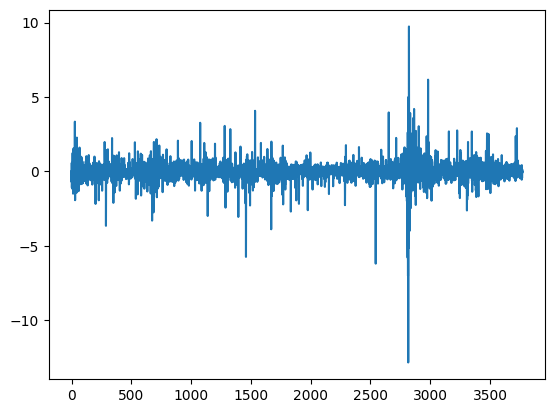

In [7]:
# 1. Current open minus previous close [%]

curr_open_prev_close = [(stock_df['Open'].iloc[i] - stock_df['Close'].iloc[i-1]) * 100 / stock_df['Close'].iloc[i-1] for i in range(1,len(stock_df))]
curr_open_prev_close = [0] + curr_open_prev_close
print(curr_open_prev_close)
plt.plot(curr_open_prev_close)

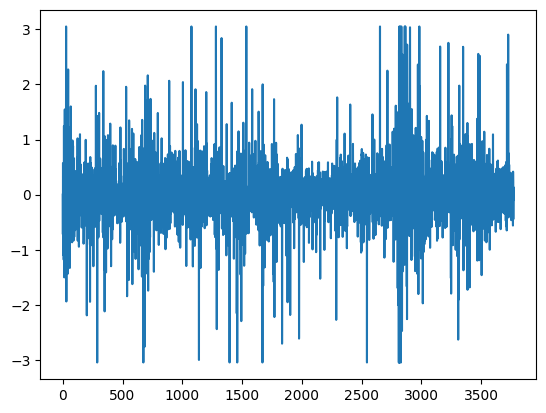

In [8]:
# Three sigma adjusted values
curr_open_prev_close_adj = adjust_to_three_sigma(curr_open_prev_close)

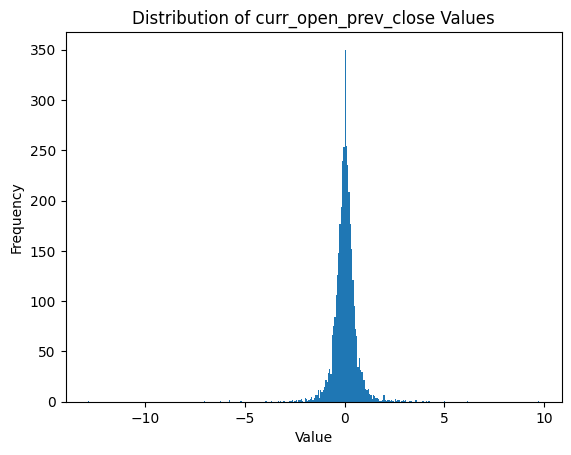

In [9]:
# Histogram
plt.hist(curr_open_prev_close, bins='auto')
plt.title('Distribution of curr_open_prev_close Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

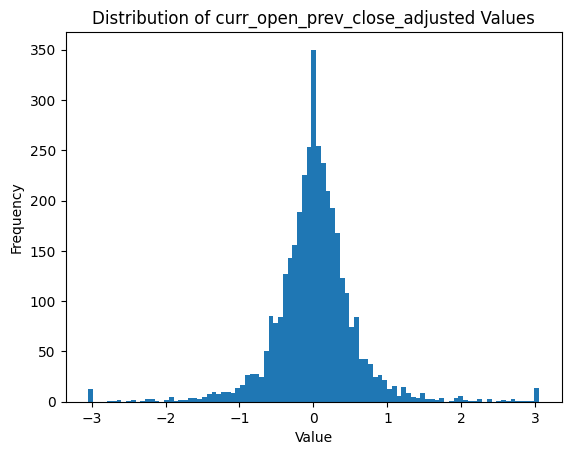

In [10]:
# Three sigma histogram
plt.hist(curr_open_prev_close_adj, bins='auto')
plt.title('Distribution of curr_open_prev_close_adjusted Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Standardized mean: 1.8837294161190356e-17
Standardized variance: 1.0000000000000002


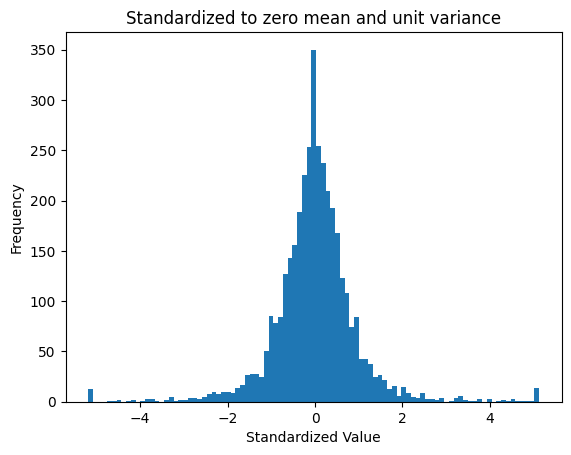

In [11]:
# Standardized histogram
curr_open_prev_close_adj_std = standardize_and_plot(curr_open_prev_close_adj)

In [12]:
# Log of standardized histogram
# curr_open_prev_close_log = log_and_plot(curr_open_prev_close_std)

In [13]:
features_df['curr_open_prev_close_adj_std'] = curr_open_prev_close_adj_std
features_df.head()

,curr_open_prev_close_adj_std
Date,
2009-01-02,-0.035593
2009-01-05,-1.252521
2009-01-06,0.932907
2009-01-07,-1.890622
2009-01-08,-0.374646


### 2. Today's close minus today's open [%] | (daily movement)

[1.1013215488880326, -0.2852777462932477, -2.166305605993866, 1.6056062073111061, 0.8920640600306078, -1.3928832069231654, -1.6419243303387188, 0.502285900765439, -2.0229909611844468, 1.8557691359894333, -0.13667738315600061, -2.0557280408313776, -0.25345761862697275, 1.1257025072867517, -1.0551013993901135, 1.7257672704559988, 0.11553385667314672, -0.31818043101917615, -0.34325291363865984, -1.657452644492421, 0.07107935239254094, 1.9294110466452206, -2.1914578585494366, 1.1132103088983096, 1.9190257514833173, -2.3314827531124744, -3.1897172247708525, 0.7568393071779453, 4.079713485388145, -0.7918603682736295, -0.9302361066951308, -0.23375053056216405, 0.44072981679188833, -0.3025391306077025, -2.1617859025567427, 0.79588048425223, -1.327432960069251, -3.9747503968774605, -0.26855618361881783, -1.878868039297511, -2.461691807159346, 1.2229287700288614, -3.345253775269325, 2.4901622811148796, -1.8490363492921602, -1.1859732728628913, 1.0469863355712046, 3.18342158474738, 0.340796941110

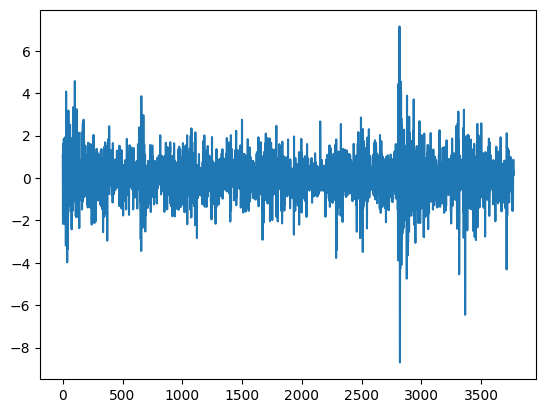

In [14]:
# 2. Today's close minus today's open [%] | (daily movement)

t_close_t_open = [(stock_df['Close'].iloc[i] - stock_df['Open'].iloc[i]) * 100 / stock_df['Open'].iloc[i] for i in range(len(stock_df))]
print(t_close_t_open)
plt.plot(t_close_t_open)

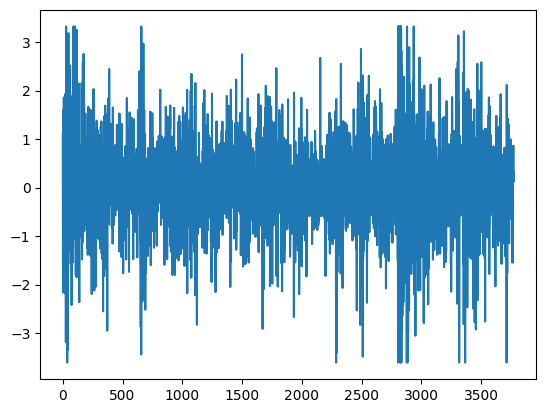

In [15]:
# Three sigma adjusted values
t_close_t_open_adj = adjust_to_three_sigma(t_close_t_open)

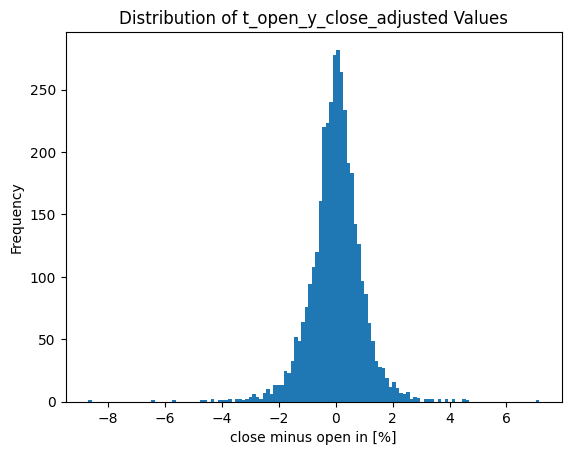

In [16]:
# Histogram
plt.hist(t_close_t_open, bins='auto')
plt.title('Distribution of t_open_y_close_adjusted Values')
plt.xlabel('close minus open in [%]')
plt.ylabel('Frequency')
plt.show()

Standardized mean: 0.0
Standardized variance: 0.9999999999999999


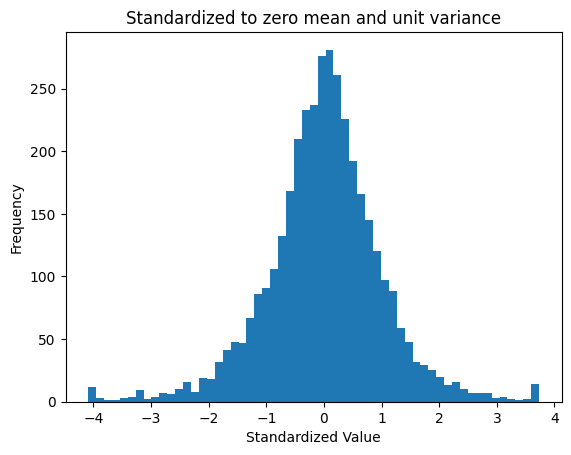

In [17]:
# Standardized histogram
t_close_t_open_adj_std = standardize_and_plot(t_close_t_open_adj)

In [18]:
# Log of standardized histogram
# t_close_t_open_log = log_and_plot(t_close_t_open_std)

In [19]:
features_df['t_close_t_open_adj_std'] = t_close_t_open_adj_std
features_df.head()

,curr_open_prev_close_adj_std,t_close_t_open_adj_std
Date,,
2009-01-02,-0.035593,1.227477
2009-01-05,-1.252521,-0.338766
2009-01-06,0.932907,-2.463496
2009-01-07,-1.890622,1.797096
2009-01-08,-0.374646,0.991109


### 3. Today's high minus today's low [%] | (volatility at timestep t)

[2.131436645112724, 1.5714897735211377, 3.396316165822474, 2.170961234671336, 1.6157930516524204, 2.282482082560911, 2.6660535328911346, 1.6047702431917665, 2.9808334702815955, 2.3349005380702277, 2.323437527423346, 3.7779824895791956, 3.059774478643712, 2.198582321393932, 2.6467719869422806, 2.991458139085206, 2.1627914073855377, 1.7341040462427746, 2.653441444001098, 2.7039773310285495, 2.335663975956292, 3.62077292600823, 3.0037854645954942, 2.338342986887035, 2.414436903377903, 3.238096691313244, 5.039728539012573, 1.5380885795821677, 5.456700246258384, 1.5793144039707778, 1.7672008111894675, 1.869824652135725, 2.4367406468861326, 2.5719682046161076, 3.029581376996574, 2.3939373527048953, 2.6565439656981265, 4.291641570993044, 2.076638162532506, 2.7763814196701473, 3.9731707487505044, 3.8105034408392413, 5.341880537819352, 2.9133875454234346, 2.943453145165238, 2.6390597743791715, 2.304741468534413, 3.8373626296924415, 2.522880163404533, 2.1643954590629257, 2.0823088693674574, 3.04

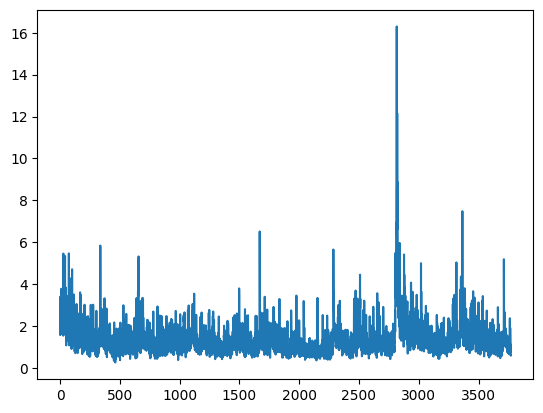

In [20]:
# 3. Today's high minus today's low [%] | (daily volatility)

t_high_t_low = [(stock_df['High'].iloc[i] - stock_df['Low'].iloc[i]) * 100 / stock_df['Low'].iloc[i] for i in range(len(stock_df))]
print(t_high_t_low)
plt.plot(t_high_t_low)

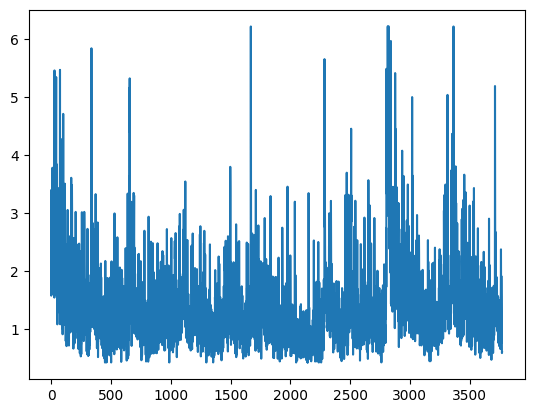

In [21]:
# Three sigma adjusted values
t_high_t_low_adj = adjust_to_three_sigma(t_high_t_low)

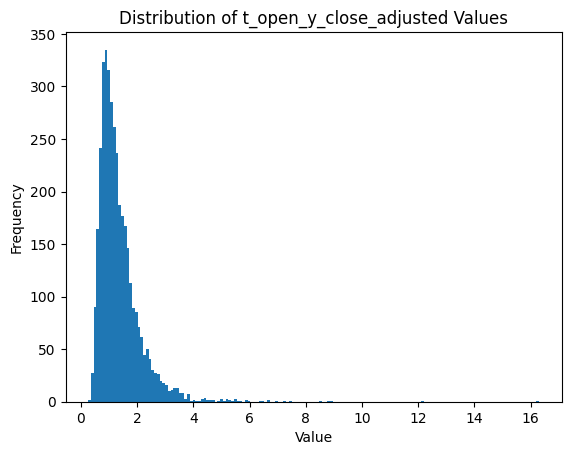

In [22]:
# Histogram
plt.hist(t_high_t_low, bins='auto')
plt.title('Distribution of t_open_y_close_adjusted Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

Standardized mean: -3.767458832238071e-17
Standardized variance: 1.0000000000000002


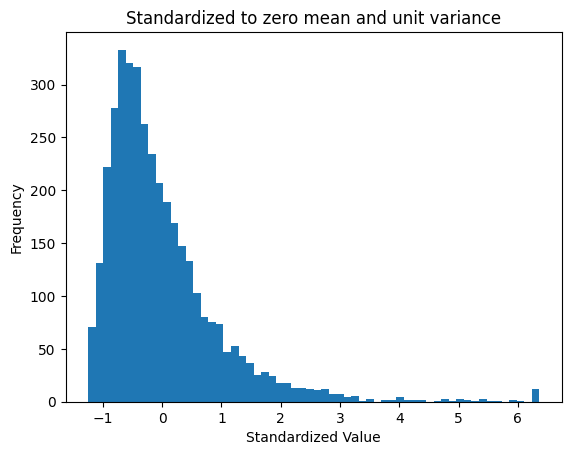

In [23]:
# Standardized histogram
t_high_t_low_adj_std = standardize_and_plot(t_high_t_low_adj)

In [24]:
# Log of standardized histogram
# t_high_t_low_log = log_and_plot(t_high_t_low)

In [25]:
features_df['t_high_t_low_adj_std'] = t_high_t_low_adj_std
features_df.head()

,curr_open_prev_close_adj_std,t_close_t_open_adj_std,t_high_t_low_adj_std
Date,,,
2009-01-02,-0.035593,1.227477,0.999193
2009-01-05,-1.252521,-0.338766,0.264100
2009-01-06,0.932907,-2.463496,2.659716
2009-01-07,-1.890622,1.797096,1.051081
2009-01-08,-0.374646,0.991109,0.322261


### 4. Bid-Ask Spread

### 5. Volume

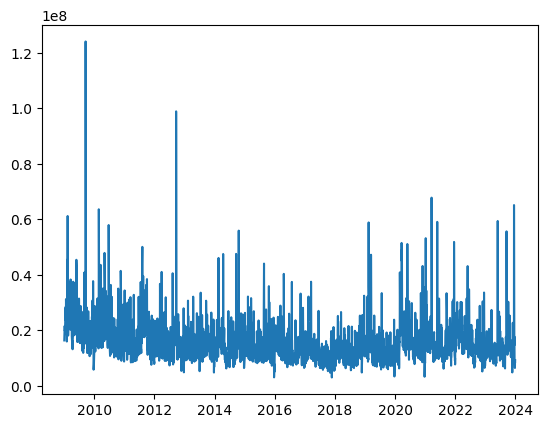

In [26]:
volume = stock_df['Volume']
plt.plot(volume)

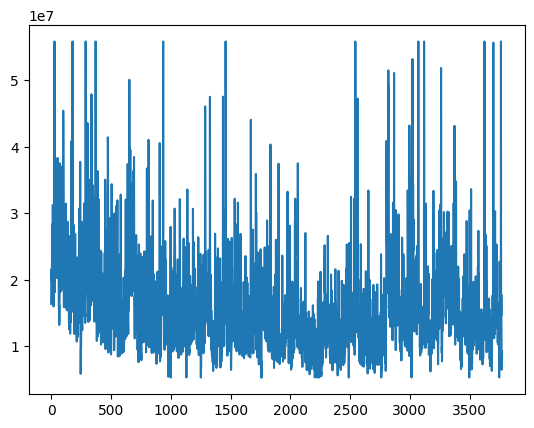

In [27]:
volume_adjusted = adjust_to_three_sigma(volume)

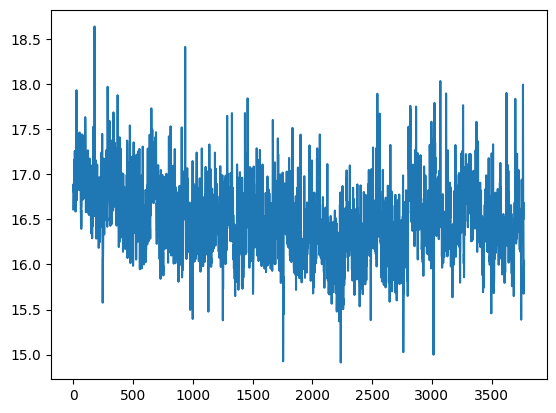

In [28]:
# Use log for volume
log_volume = [np.log(value) for value in stock_df['Volume']]
plt.plot(log_volume)

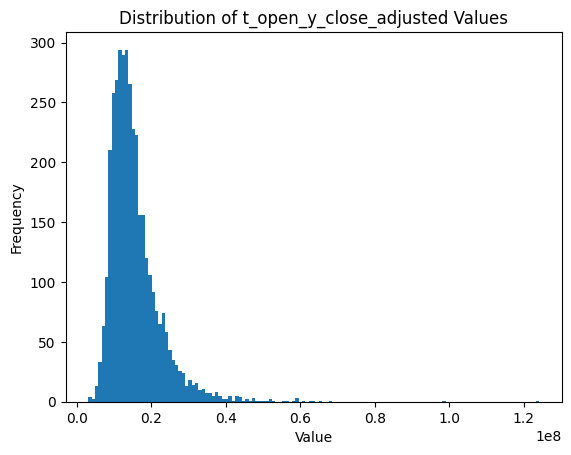

In [29]:
# Histogram
plt.hist(volume, bins='auto')
plt.title('Distribution of t_open_y_close_adjusted Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [30]:
# log_and_plot(volume)

Standardized mean: -3.029036901119409e-15
Standardized variance: 1.0


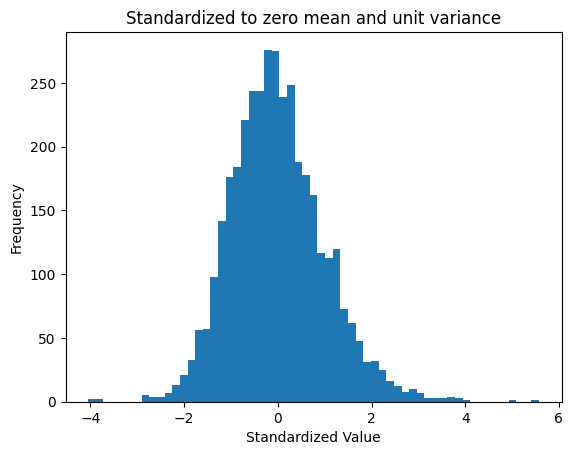

In [31]:
volume_log_std = standardize_and_plot(log_volume)

In [32]:
features_df['volume_log_std'] = volume_log_std
features_df.head()

,curr_open_prev_close_adj_std,t_close_t_open_adj_std,t_high_t_low_adj_std,volume_log_std
Date,,,,
2009-01-02,-0.035593,1.227477,0.999193,0.339165
2009-01-05,-1.252521,-0.338766,0.264100,0.889410
2009-01-06,0.932907,-2.463496,2.659716,1.022619
2009-01-07,-1.890622,1.797096,1.051081,1.055540
2009-01-08,-0.374646,0.991109,0.322261,0.870159


### 6. Month of year

In [33]:
# 6. Month of year

def month_of_year(month):
    radians = (month - 1) * (np.pi / 6)
    return [np.cos(radians), np.sin(radians)]

features_df['month_of_year'] = features_df.index.month.map(month_of_year)
features_df


,curr_open_prev_close_adj_std,t_close_t_open_adj_std,t_high_t_low_adj_std,volume_log_std,month_of_year
Date,,,,,
2009-01-02,-0.035593,1.227477,0.999193,0.339165,"[1.0, 0.0]"
2009-01-05,-1.252521,-0.338766,0.264100,0.889410,"[1.0, 0.0]"
2009-01-06,0.932907,-2.463496,2.659716,1.022619,"[1.0, 0.0]"
2009-01-07,-1.890622,1.797096,1.051081,1.055540,"[1.0, 0.0]"
2009-01-08,-0.374646,0.991109,0.322261,0.870159,"[1.0, 0.0]"
...,...,...,...,...,...
2023-12-22,0.343846,0.372171,-0.803373,-1.196261,"[0.8660254037844384, -0.5000000000000004]"
2023-12-26,-0.790189,0.956221,-0.329232,-2.076329,"[0.8660254037844384, -0.5000000000000004]"
2023-12-27,0.195634,0.118309,-0.967206,-1.333924,"[0.8660254037844384, -0.5000000000000004]"


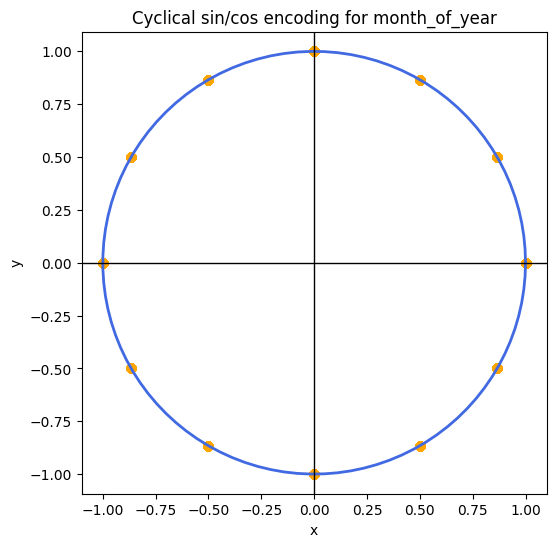

In [34]:
plot_cyclical_encoding('month_of_year')

### 7. Week of year

In [35]:
# 7. Week of year

def week_of_year(week):
    radians = (week - 1) * (2 * np.pi / 52)
    return [np.cos(radians), np.sin(radians)]

features_df['week_of_year'] = features_df.index.isocalendar().week.map(week_of_year)
features_df

,curr_open_prev_close_adj_std,t_close_t_open_adj_std,t_high_t_low_adj_std,volume_log_std,month_of_year,week_of_year
Date,,,,,,
2009-01-02,-0.035593,1.227477,0.999193,0.339165,"[1.0, 0.0]","[1.0, 0.0]"
2009-01-05,-1.252521,-0.338766,0.264100,0.889410,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]"
2009-01-06,0.932907,-2.463496,2.659716,1.022619,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]"
2009-01-07,-1.890622,1.797096,1.051081,1.055540,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]"
2009-01-08,-0.374646,0.991109,0.322261,0.870159,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]"
...,...,...,...,...,...,...
2023-12-22,0.343846,0.372171,-0.803373,-1.196261,"[0.8660254037844384, -0.5000000000000004]","[0.9709418174260518, -0.23931566428755865]"
2023-12-26,-0.790189,0.956221,-0.329232,-2.076329,"[0.8660254037844384, -0.5000000000000004]","[0.992708874098054, -0.12053668025532363]"
2023-12-27,0.195634,0.118309,-0.967206,-1.333924,"[0.8660254037844384, -0.5000000000000004]","[0.992708874098054, -0.12053668025532363]"


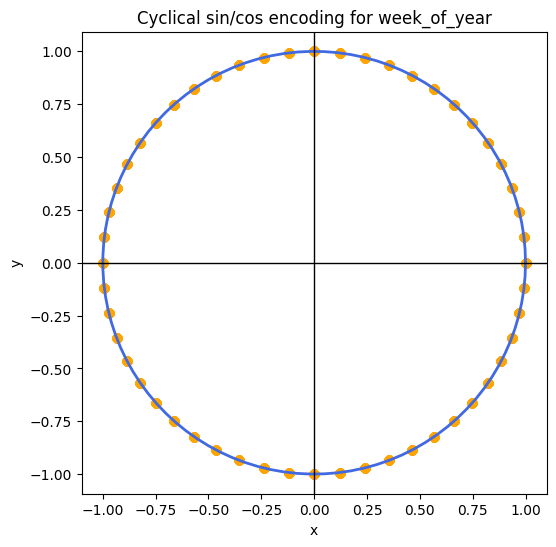

In [36]:
plot_cyclical_encoding('week_of_year')

In [37]:
# Test for the week number
'''
test_df = features_df.copy()
test_df['week_number'] = test_df.index.isocalendar().week
test_df
'''

"\ntest_df = features_df.copy()\ntest_df['week_number'] = test_df.index.isocalendar().week\ntest_df\n"

In [38]:
print(features_df.index.day)

Index([ 2,  5,  6,  7,  8,  9, 12, 13, 14, 15,
       ...
       15, 18, 19, 20, 21, 22, 26, 27, 28, 29],
      dtype='int32', name='Date', length=3772)


### 8. Day of year

In [39]:
# 8. Day of year - leap years are removed from the data so we always divide by 365

def day_of_year(day):
    radians = (day - 1) * (2 * np.pi / 365)
    return [np.cos(radians), np.sin(radians)]

features_df['day_of_year'] = features_df.index.map(lambda x: day_of_year(x.dayofyear))
features_df

,curr_open_prev_close_adj_std,t_close_t_open_adj_std,t_high_t_low_adj_std,volume_log_std,month_of_year,week_of_year,day_of_year
Date,,,,,,,
2009-01-02,-0.035593,1.227477,0.999193,0.339165,"[1.0, 0.0]","[1.0, 0.0]","[0.9998518392091162, 0.017213356155834685]"
2009-01-05,-1.252521,-0.338766,0.264100,0.889410,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]","[0.9976303053065857, 0.06880242680231986]"
2009-01-06,0.932907,-2.463496,2.659716,1.022619,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]","[0.9962981749346078, 0.08596479873744646]"
2009-01-07,-1.890622,1.797096,1.051081,1.055540,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]","[0.9946708199115211, 0.10310169744743485]"
2009-01-08,-0.374646,0.991109,0.322261,0.870159,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]","[0.9927487224577402, 0.1202080448993527]"
...,...,...,...,...,...,...,...
2023-12-22,0.343846,0.372171,-0.803373,-1.196261,"[0.8660254037844384, -0.5000000000000004]","[0.9709418174260518, -0.23931566428755865]","[0.9852201067560606, -0.1712931441814778]"
2023-12-26,-0.790189,0.956221,-0.329232,-2.076329,"[0.8660254037844384, -0.5000000000000004]","[0.992708874098054, -0.12053668025532363]","[0.9946708199115211, -0.10310169744743544]"
2023-12-27,0.195634,0.118309,-0.967206,-1.333924,"[0.8660254037844384, -0.5000000000000004]","[0.992708874098054, -0.12053668025532363]","[0.9962981749346077, -0.0859647987374467]"


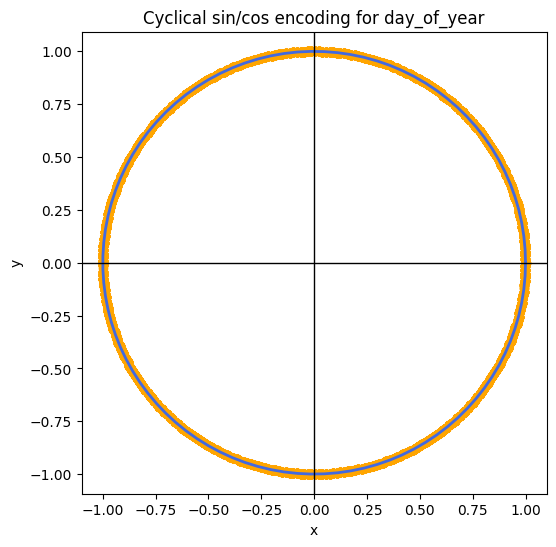

In [40]:
plot_cyclical_encoding('day_of_year')

### 9. Day of month

In [41]:
# For day_of_month we normalize by the number of days in the specific month, since there is no additional timespan from 
# the 28th of February to the 1st of March or from the 30th of September to the 1st of October

def day_of_month(row_index):
    day = row_index.day
    month = row_index.month
    long_months = [1, 3, 5, 7, 8, 10, 12]
    shorter_months = [2, 4, 6, 9, 11]
    if month in long_months:
        radians = (day - 1) * (2 * np.pi / 31)
    elif month in shorter_months:
        if month == 2:
            radians = (day - 1) * (2 * np.pi / 28)
        else:
            radians = (day - 1) * (2 * np.pi / 30)
    return [np.cos(radians), np.sin(radians)]

features_df['day_of_month'] = features_df.index.map(day_of_month)
features_df

,curr_open_prev_close_adj_std,t_close_t_open_adj_std,t_high_t_low_adj_std,volume_log_std,month_of_year,week_of_year,day_of_year,day_of_month
Date,,,,,,,,
2009-01-02,-0.035593,1.227477,0.999193,0.339165,"[1.0, 0.0]","[1.0, 0.0]","[0.9998518392091162, 0.017213356155834685]","[0.9795299412524945, 0.20129852008866006]"
2009-01-05,-1.252521,-0.338766,0.264100,0.889410,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]","[0.9976303053065857, 0.06880242680231986]","[0.6889669190756866, 0.72479278722912]"
2009-01-06,0.932907,-2.463496,2.659716,1.022619,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]","[0.9962981749346078, 0.08596479873744646]","[0.5289640103269624, 0.8486442574947509]"
2009-01-07,-1.890622,1.797096,1.051081,1.055540,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]","[0.9946708199115211, 0.10310169744743485]","[0.3473052528448203, 0.9377521321470804]"
2009-01-08,-0.374646,0.991109,0.322261,0.870159,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]","[0.9927487224577402, 0.1202080448993527]","[0.1514277775045767, 0.9884683243281114]"
...,...,...,...,...,...,...,...,...
2023-12-22,0.343846,0.372171,-0.803373,-1.196261,"[0.8660254037844384, -0.5000000000000004]","[0.9709418174260518, -0.23931566428755865]","[0.9852201067560606, -0.1712931441814778]","[-0.44039415155763423, -0.8978045395707417]"
2023-12-26,-0.790189,0.956221,-0.329232,-2.076329,"[0.8660254037844384, -0.5000000000000004]","[0.992708874098054, -0.12053668025532363]","[0.9946708199115211, -0.10310169744743544]","[0.3473052528448203, -0.9377521321470804]"
2023-12-27,0.195634,0.118309,-0.967206,-1.333924,"[0.8660254037844384, -0.5000000000000004]","[0.992708874098054, -0.12053668025532363]","[0.9962981749346077, -0.0859647987374467]","[0.5289640103269624, -0.8486442574947509]"


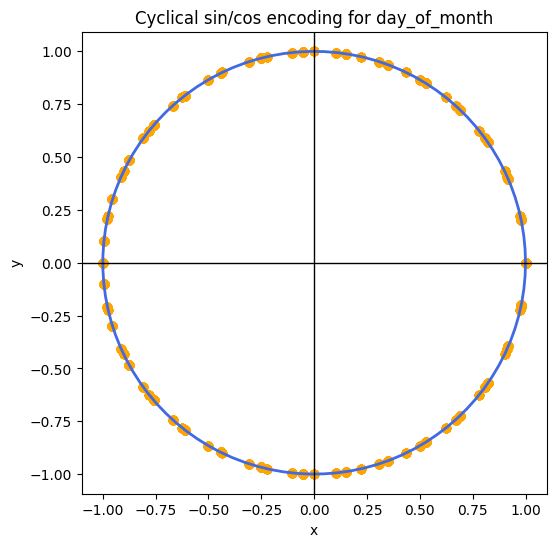

In [42]:
plot_cyclical_encoding('day_of_month')

In [43]:
# Print out the first 4 January values in the features dataframe (365 * 4 == 1460)
for i in range(len(features_df)):
    if features_df.index.month[i] == 1 and i < 1460:
        print(features_df.iloc[i]["day_of_month"])
        print(features_df.index.day[i])

[0.9795299412524945, 0.20129852008866006]
2
[0.6889669190756866, 0.72479278722912]
5
[0.5289640103269624, 0.8486442574947509]
6
[0.3473052528448203, 0.9377521321470804]
7
[0.1514277775045767, 0.9884683243281114]
8
[-0.05064916883871264, 0.9987165071710528]
9
[-0.6121059825476629, 0.7907757369376985]
12
[-0.758758122692791, 0.6513724827222223]
13
[-0.8743466161445821, 0.48530196253108104]
14
[-0.9541392564000488, 0.29936312297335804]
15
[-0.9948693233918952, 0.10116832198743228]
16
[-0.7587581226927911, -0.651372482722222]
20
[-0.6121059825476627, -0.7907757369376986]
21
[-0.44039415155763423, -0.8978045395707417]
22
[-0.2506525322587205, -0.9680771188662043]
23
[0.3473052528448203, -0.9377521321470804]
26
[0.5289640103269624, -0.8486442574947509]
27
[0.6889669190756865, -0.72479278722912]
28
[0.8207634412072763, -0.5712682150947924]
29
[0.9189578116202306, -0.3943558551133187]
30
[0.8207634412072763, 0.5712682150947923]
4
[0.6889669190756866, 0.72479278722912]
5
[0.5289640103269624, 0.

### 10. Day of week

In [44]:
# 10. Day of week

def day_of_week(day):
    radians = (day - 1) * (2 * np.pi / 7)
    return [np.cos(radians), np.sin(radians)]

features_df['day_of_week'] = features_df.index.isocalendar().day.map(day_of_week)
features_df

,curr_open_prev_close_adj_std,t_close_t_open_adj_std,t_high_t_low_adj_std,volume_log_std,month_of_year,week_of_year,day_of_year,day_of_month,day_of_week
Date,,,,,,,,,
2009-01-02,-0.035593,1.227477,0.999193,0.339165,"[1.0, 0.0]","[1.0, 0.0]","[0.9998518392091162, 0.017213356155834685]","[0.9795299412524945, 0.20129852008866006]","[-0.9009688679024191, -0.433883739117558]"
2009-01-05,-1.252521,-0.338766,0.264100,0.889410,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]","[0.9976303053065857, 0.06880242680231986]","[0.6889669190756866, 0.72479278722912]","[1.0, 0.0]"
2009-01-06,0.932907,-2.463496,2.659716,1.022619,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]","[0.9962981749346078, 0.08596479873744646]","[0.5289640103269624, 0.8486442574947509]","[0.6234898018587336, 0.7818314824680298]"
2009-01-07,-1.890622,1.797096,1.051081,1.055540,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]","[0.9946708199115211, 0.10310169744743485]","[0.3473052528448203, 0.9377521321470804]","[-0.22252093395631434, 0.9749279121818236]"
2009-01-08,-0.374646,0.991109,0.322261,0.870159,"[1.0, 0.0]","[0.992708874098054, 0.12053668025532305]","[0.9927487224577402, 0.1202080448993527]","[0.1514277775045767, 0.9884683243281114]","[-0.900968867902419, 0.43388373911755823]"
...,...,...,...,...,...,...,...,...,...
2023-12-22,0.343846,0.372171,-0.803373,-1.196261,"[0.8660254037844384, -0.5000000000000004]","[0.9709418174260518, -0.23931566428755865]","[0.9852201067560606, -0.1712931441814778]","[-0.44039415155763423, -0.8978045395707417]","[-0.9009688679024191, -0.433883739117558]"
2023-12-26,-0.790189,0.956221,-0.329232,-2.076329,"[0.8660254037844384, -0.5000000000000004]","[0.992708874098054, -0.12053668025532363]","[0.9946708199115211, -0.10310169744743544]","[0.3473052528448203, -0.9377521321470804]","[0.6234898018587336, 0.7818314824680298]"
2023-12-27,0.195634,0.118309,-0.967206,-1.333924,"[0.8660254037844384, -0.5000000000000004]","[0.992708874098054, -0.12053668025532363]","[0.9962981749346077, -0.0859647987374467]","[0.5289640103269624, -0.8486442574947509]","[-0.22252093395631434, 0.9749279121818236]"


In [45]:
print(features_df.index.isocalendar().day)

Date
2009-01-02    5
2009-01-05    1
2009-01-06    2
2009-01-07    3
2009-01-08    4
             ..
2023-12-22    5
2023-12-26    2
2023-12-27    3
2023-12-28    4
2023-12-29    5
Name: day, Length: 3772, dtype: UInt32


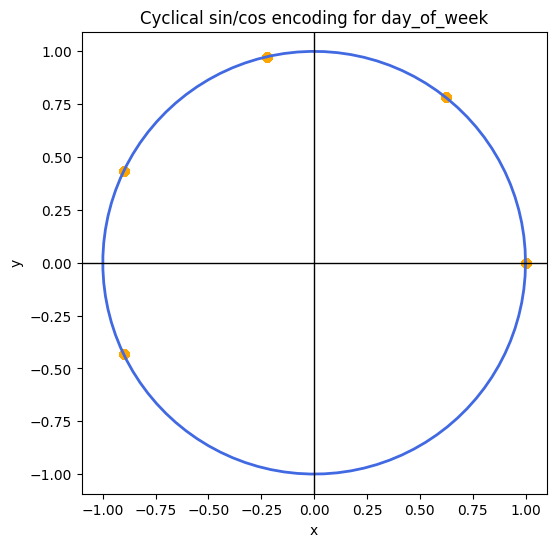

In [46]:
plot_cyclical_encoding('day_of_week')

### 11. Hour of day

In [ ]:
# 11. Hour of day - CURRENTLY: daily resolution on public data - implement later with Energy data

'''
def hour_of_day(hour):
    radians = (hour - 1) * (2 * np.pi / 7)
    return [np.cos(radians), np.sin(radians)]

features_df['hour_of_day'] = features_df.index.hour.map(hour_of_day)
features_df
'''

In [ ]:
plot_cyclical_encoding('hour_of_day')

### Create tensor from features